# Embed SLAM Models Comparison

This notebook compares the models from `embed_slam`: ConceptFusion, DINOFusion, XFusion, and NARadioFusion.

In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

from vlm_eval.core import EncoderRegistry
from vlm_eval.encoders import *

# Ensure models are registered
print("Available encoders:", EncoderRegistry.list_available())

2025-12-12 08:33:39.487472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Available encoders: ['clip', 'concept_fusion', 'dino_fusion', 'naradio', 'naradio_fusion', 'radio', 'simple_cnn', 'x_fusion']


In [2]:
# Load Models
# Note: You need to have the necessary checkpoints and dependencies installed.

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

models = {}
model_names = ["concept_fusion", "dino_fusion", "x_fusion", "naradio_fusion"]

for name in model_names:
    try:
        print(f"Loading {name}...")
        models[name] = EncoderRegistry.get(name, device=device)
        print(f"Loaded {name}")
    except Exception as e:
        print(f"Failed to load {name}: {e}")


Using device: cuda
Loading concept_fusion...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


Loaded concept_fusion
Loading dino_fusion...
Loaded dino_fusion
Loading x_fusion...


Device set to use cuda


Loaded x_fusion
Loading naradio_fusion...


Using cache found in /home/jovyan/.cache/torch/hub/NVlabs_RADIO_main


Loaded naradio_fusion


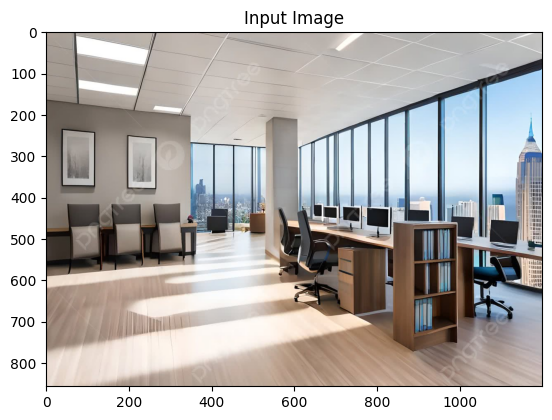

Image tensor shape: torch.Size([1, 3, 857, 1200])


In [3]:
# Load a sample image
# Replace with your image path
image_path = "../examples/example_office.jpg"
if not os.path.exists(image_path):
    # Create a dummy image if not exists
    dummy_img = Image.fromarray(np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8))
    dummy_img.save(image_path)
    print(f"Created dummy image at {image_path}")

image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title("Input Image")
plt.show()

# Preprocess
image_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
image_tensor = image_tensor.unsqueeze(0).to(device)
print("Image tensor shape:", image_tensor.shape)

Running concept_fusion...


RuntimeError: expected scalar type Float but found Half

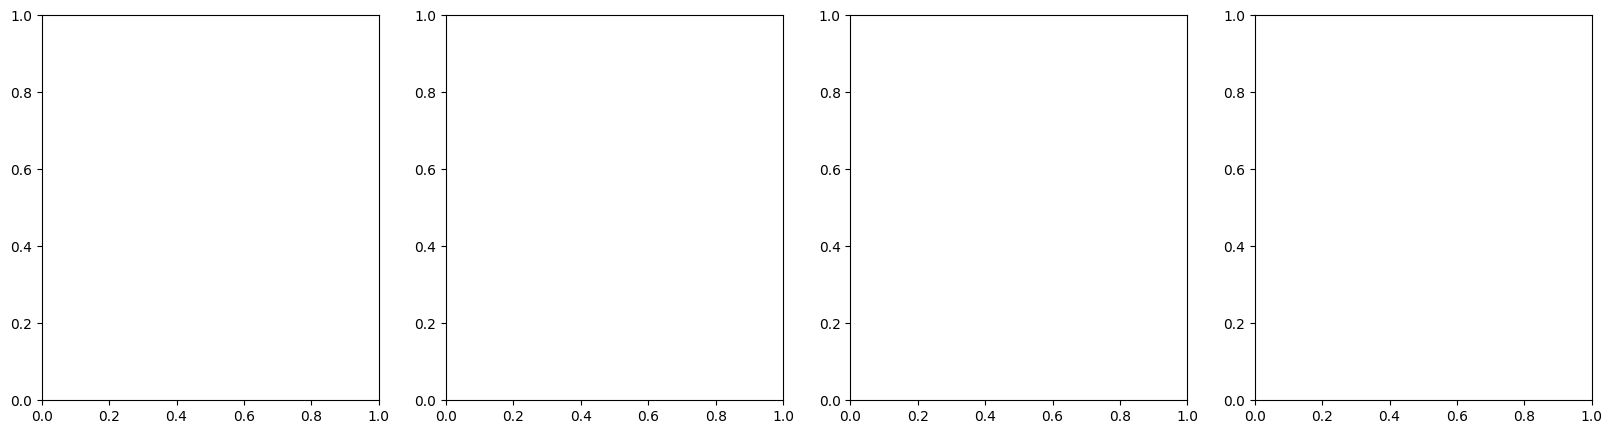

In [4]:
# Run Inference and Compare
text_query = "chair"

fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
if len(models) == 1:
    axes = [axes]

for i, (name, model) in enumerate(models.items()):
    print(f"Running {name}...")
    with torch.no_grad():
        # Get image features
        features = model(image_tensor) # (B, C, H, W)
        
        # Get text features
        text_emb = model.encode_text([text_query]) # (1, C)
        
        # Compute similarity
        # features: (1, C, H, W)
        # text_emb: (1, C)
        sim = torch.einsum("bchw,bc->bhw", features, text_emb)
        
        sim_map = sim[0].cpu().numpy()
        
        axes[i].imshow(sim_map, cmap="jet")
        axes[i].set_title(f"{name} - '{text_query}'")
        axes[i].axis("off")
    torch.cuda.empty_cache()

plt.tight_layout()
plt.show()

Running concept_fusion...
  !! skipping concept_fusion: RuntimeError: expected scalar type Float but found Half
Running dino_fusion...
  !! skipping dino_fusion: RuntimeError: shape '[1, 1024, 14, 14]' is invalid for input of size 204800
Running x_fusion...
  !! skipping x_fusion: OutOfMemoryError: CUDA out of memory. Tried to allocate 22.50 GiB. GPU 0 has a total capacity of 39.49 GiB of which 1.27 GiB is free. Including non-PyTorch memory, this process has 38.21 GiB memory in use. Of the allocated memory 37.64 GiB is allocated by PyTorch, and 69.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running naradio_fusion...
  -> resized to (768, 1024)


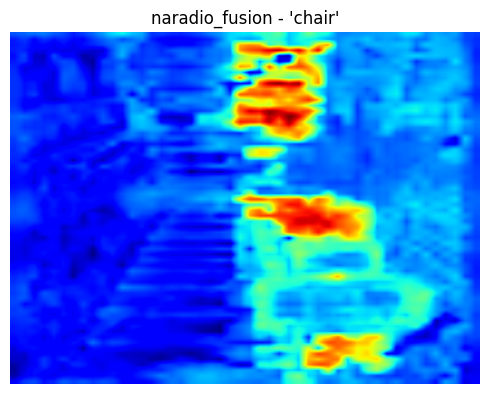

In [5]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

VALID_RESOLUTIONS = [
    (192, 192), (224, 224), (256, 256), (288, 288), (320, 320), (384, 384),
    (448, 448), (512, 512), (640, 640), (768, 768), (896, 896), (1024, 1024),
    (256, 384), (384, 256), (336, 448), (448, 336), (512, 768), (768, 512),
    (512, 896), (896, 512), (720, 1280), (800, 1280), (768, 1024), (1024, 768),
]

def is_naradio_like(enc):
    return hasattr(getattr(enc, "model", None), "naradio") and hasattr(enc.model.naradio, "input_resolution")

def pick_best_resolution(hw, candidates):
    h, w = hw
    ar = w / h
    best = None
    best_score = float("inf")
    for H, W in candidates:
        ar2 = W / H
        score = abs(math.log(ar2 / ar)) + 0.15 * abs(math.log((H * W) / (h * w)))
        if score < best_score:
            best_score = score
            best = (H, W)
    return best

def letterbox_to(x, target_hw):
    B, C, H, W = x.shape
    th, tw = target_hw
    scale = min(tw / W, th / H)
    nh = int(round(H * scale))
    nw = int(round(W * scale))
    x = F.interpolate(x, size=(nh, nw), mode="bilinear", align_corners=False)

    pad_h = th - nh
    pad_w = tw - nw
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return F.pad(x, (left, right, top, bottom), value=0.0)

def ensure_bchw(feats):
    # Accept (B,C,H,W). Anything else -> error.
    if not isinstance(feats, torch.Tensor):
        raise TypeError(f"Model returned {type(feats)} not a Tensor")
    if feats.ndim != 4:
        raise ValueError(f"Expected features (B,C,H,W) but got shape {tuple(feats.shape)}")
    return feats

text_query = "chair"

# run models, collect successful ones for plotting
ok = []

for name, model in models.items():
    print(f"Running {name}...")
    try:
        if is_naradio_like(model):
            target_hw = pick_best_resolution(image_tensor.shape[-2:], VALID_RESOLUTIONS)
            img_in = letterbox_to(image_tensor, target_hw)
            print(f"  -> resized to {target_hw}")
        else:
            img_in = image_tensor

        with torch.no_grad():
            feats = ensure_bchw(model(img_in))
            txt = model.encode_text([text_query])
            feats = F.normalize(feats, dim=1)
            txt = F.normalize(txt, dim=1)
            sim = torch.einsum("bchw,bc->bhw", feats, txt)[0].cpu().numpy()

        ok.append((name, sim))
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"  !! skipping {name}: {type(e).__name__}: {e}")

# plot only successful models
if len(ok) == 0:
    raise RuntimeError("No models ran successfully.")

fig, axes = plt.subplots(1, len(ok), figsize=(5 * len(ok), 5))
if len(ok) == 1:
    axes = [axes]

for ax, (name, sim_map) in zip(axes, ok):
    ax.imshow(sim_map, cmap="jet")
    ax.set_title(f"{name} - '{text_query}'")
    ax.axis("off")

plt.tight_layout()
plt.show()


Running concept_fusion...
  -> native
Running dino_fusion...
  -> resize 224x224 (ViT 14x14 grid)
  !! skipping dino_fusion: RuntimeError: shape '[1, 1024, 14, 14]' is invalid for input of size 204800
Running x_fusion...
  -> native
  !! skipping x_fusion: OutOfMemoryError: CUDA out of memory. Tried to allocate 22.50 GiB. GPU 0 has a total capacity of 39.49 GiB of which 1.21 GiB is free. Including non-PyTorch memory, this process has 38.27 GiB memory in use. Of the allocated memory 37.68 GiB is allocated by PyTorch, and 93.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running naradio_fusion...
  -> letterbox (768, 1024)


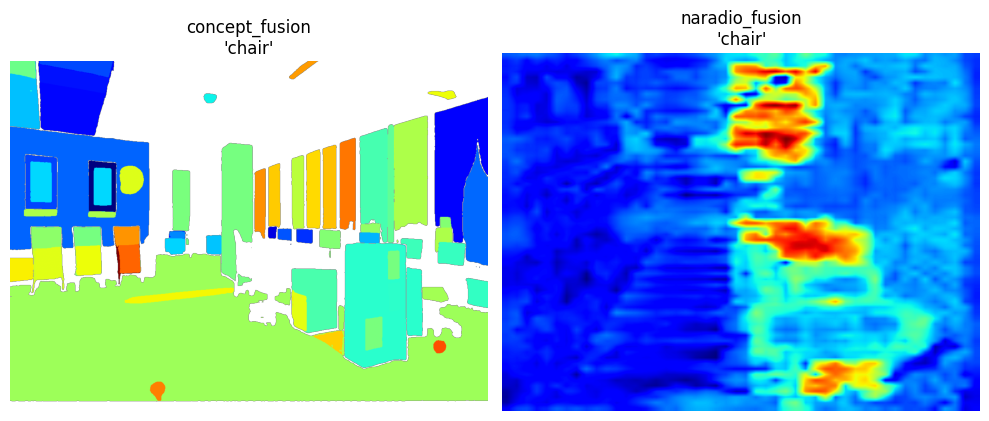

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

VALID_RESOLUTIONS_NARADIO = [
    (192, 192), (224, 224), (256, 256), (288, 288), (320, 320), (384, 384),
    (448, 448), (512, 512), (640, 640), (768, 768), (896, 896), (1024, 1024),
    (256, 384), (384, 256), (336, 448), (448, 336), (512, 768), (768, 512),
    (512, 896), (896, 512), (720, 1280), (800, 1280), (768, 1024), (1024, 768),
]

def is_naradio_like(enc):
    return hasattr(getattr(enc, "model", None), "naradio") and hasattr(enc.model.naradio, "input_resolution")

def pick_best_resolution(hw, candidates):
    h, w = hw
    ar = w / h
    best = None
    best_score = float("inf")
    for H, W in candidates:
        ar2 = W / H
        score = abs(math.log(ar2 / ar)) + 0.15 * abs(math.log((H * W) / (h * w)))
        if score < best_score:
            best_score = score
            best = (H, W)
    return best

def resize_to(x, hw):
    return F.interpolate(x, size=hw, mode="bilinear", align_corners=False)

def letterbox_to(x, target_hw):
    B, C, H, W = x.shape
    th, tw = target_hw
    scale = min(tw / W, th / H)
    nh = int(round(H * scale))
    nw = int(round(W * scale))
    x = F.interpolate(x, size=(nh, nw), mode="bilinear", align_corners=False)

    pad_h = th - nh
    pad_w = tw - nw
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return F.pad(x, (left, right, top, bottom), value=0.0)

def ensure_bchw(feats):
    if not isinstance(feats, torch.Tensor):
        raise TypeError(f"Model returned {type(feats)} not a Tensor")
    if feats.ndim != 4:
        raise ValueError(f"Expected (B,C,H,W), got {tuple(feats.shape)}")
    return feats

def prepare_input_for_model(name, model, image_tensor):
    lname = name.lower()

    # SAM-based fusion models are broken right now (segmenter output mismatch)
    # BUT we fixed it in the library, so we can try running them!
    # if "concept_fusion" in lname or "x_fusion" in lname:
    #    raise RuntimeError("SAM-based segmenter output mismatch; needs library patch. Skipping.")

    # DINO/VIT fusion: force 224x224 (14x14 tokens for patch=16)
    if "dino" in lname:
        return resize_to(image_tensor, (224, 224)), "resize 224x224 (ViT 14x14 grid)"

    # NARadio: letterbox to a supported resolution
    if is_naradio_like(model):
        target_hw = pick_best_resolution(image_tensor.shape[-2:], VALID_RESOLUTIONS_NARADIO)
        return letterbox_to(image_tensor, target_hw), f"letterbox {target_hw}"

    # default: no change
    return image_tensor, "native"

# --- Run & plot ---
text_query = "chair"
ok = []

for name, model in models.items():
    print(f"Running {name}...")
    try:
        img_in, how = prepare_input_for_model(name, model, image_tensor)
        print(f"  -> {how}")

        with torch.no_grad():
            feats = ensure_bchw(model(img_in))
            txt = model.encode_text([text_query])

            feats = F.normalize(feats, dim=1)
            txt = F.normalize(txt, dim=1)
            
            # Ensure same dtype
            txt = txt.to(dtype=feats.dtype)

            sim = torch.einsum("bchw,bc->bhw", feats, txt)[0].cpu().numpy()

        ok.append((name, sim))
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"  !! skipping {name}: {type(e).__name__}: {e}")

if not ok:
    raise RuntimeError("No models ran successfully.")

fig, axes = plt.subplots(1, len(ok), figsize=(5 * len(ok), 5))
if len(ok) == 1:
    axes = [axes]

for ax, (name, sim_map) in zip(axes, ok):
    ax.imshow(sim_map, cmap="jet")
    ax.set_title(f"{name}\n'{text_query}'")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

VALID_RESOLUTIONS = [
    (192, 192), (224, 224), (256, 256), (288, 288), (320, 320), (384, 384),
    (448, 448), (512, 512), (640, 640), (768, 768), (896, 896), (1024, 1024),
    (256, 384), (384, 256), (336, 448), (448, 336), (512, 768), (768, 512),
    (512, 896), (896, 512), (720, 1280), (800, 1280), (768, 1024), (1024, 768),
]

def tensor_to_img(x):  # (1,3,H,W) -> (H,W,3) float [0,1]
    x = x[0].detach().cpu().permute(1, 2, 0).numpy()
    return np.clip(x, 0.0, 1.0)

def normalize_map(m):
    m = m.astype(np.float32)
    m = m - m.min()
    return m / (m.max() + 1e-8)

def letterbox_to(x, target_hw):
    # x: (B,C,H,W), target_hw: (H,W)
    B, C, H, W = x.shape
    th, tw = target_hw

    scale = min(tw / W, th / H)
    nh = int(round(H * scale))
    nw = int(round(W * scale))

    x = F.interpolate(x, size=(nh, nw), mode="bilinear", align_corners=False)

    pad_h = th - nh
    pad_w = tw - nw
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    return F.pad(x, (left, right, top, bottom), value=0.0)

def run_all_resolutions_for_model(model, image_tensor, text_query, resolutions, device=None):
    if device is None:
        device = image_tensor.device

    # encode text once
    with torch.no_grad():
        text_emb = model.encode_text([text_query]).to(device)
        text_emb = F.normalize(text_emb, dim=1)

    results = []
    for hw in resolutions:
        img_in = letterbox_to(image_tensor, hw)

        with torch.no_grad():
            feats = model(img_in)              # (1,C,H,W)
            feats = F.normalize(feats, dim=1)

            sim = torch.einsum("bchw,bc->bhw", feats, text_emb)  # (1,H,W)
            sim_map = sim[0].detach().cpu().numpy()
            sim_norm = normalize_map(sim_map)

        results.append((hw, img_in.detach().cpu(), sim_norm))

        # keep GPU memory sane
        del img_in, feats, sim

    return results

def plot_resolution_grid(model_name, image_tensor, text_query, results, max_cols=4):
    orig_img = tensor_to_img(image_tensor)

    # We will plot: 1 "Original" + for each res: (heatmap, overlay)
    n_tiles = 1 + 2 * len(results)
    ncols = max_cols
    nrows = math.ceil(n_tiles / ncols)

    fig = plt.figure(figsize=(4.2 * ncols, 3.6 * nrows))
    fig.suptitle(f"{model_name} — all resolutions — query='{text_query}'", fontsize=14)

    def add_ax(idx):
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        ax.axis("off")
        return ax

    k = 0

    # (0) Original
    ax = add_ax(k); k += 1
    ax.imshow(orig_img)
    ax.set_title("Original", fontsize=10)

    # Each resolution: heatmap + overlay (on the exact letterboxed input)
    for (H, W), img_in_cpu, sim_norm in results:
        in_img = tensor_to_img(img_in_cpu)

        ax = add_ax(k); k += 1
        ax.imshow(sim_norm, cmap="jet")
        ax.set_title(f"Heatmap {H}×{W}", fontsize=10)

        ax = add_ax(k); k += 1
        ax.imshow(in_img)
        ax.imshow(sim_norm, cmap="jet", alpha=0.45)
        ax.set_title(f"Overlay {H}×{W}", fontsize=10)

    plt.tight_layout()
    plt.show()

# ---- run for all models ----
text_query = "chair"

for name, model in models.items():
    print(f"\n=== {name} ===")
    results = run_all_resolutions_for_model(
        model=model,
        image_tensor=image_tensor,
        text_query=text_query,
        resolutions=VALID_RESOLUTIONS,
    )
    plot_resolution_grid(name, image_tensor, text_query, results, max_cols=4)
    torch.cuda.empty_cache()


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- if your image_tensor is ImageNet-normalized, set these; else set to None ----
IMAGENET_MEAN = None  # (0.485, 0.456, 0.406)
IMAGENET_STD  = None  # (0.229, 0.224, 0.225)

def denorm_if_needed(x):
    # x: (1,3,H,W)
    if IMAGENET_MEAN is None or IMAGENET_STD is None:
        return x
    mean = torch.tensor(IMAGENET_MEAN, device=x.device).view(1,3,1,1)
    std  = torch.tensor(IMAGENET_STD,  device=x.device).view(1,3,1,1)
    return x * std + mean

def to_float01_rgb(x):
    # ensure model input is float in [0,1]
    x = denorm_if_needed(x)
    return x.clamp(0, 1)

def tensor_to_img01(x):  # (1,3,H,W) -> (H,W,3)
    x = x[0].detach().cpu().permute(1,2,0).numpy()
    return np.clip(x, 0.0, 1.0)

def letterbox_with_mask(x, target_hw):
    # returns padded image and a mask of valid (non-pad) pixels
    B, C, H, W = x.shape
    th, tw = target_hw
    scale = min(tw / W, th / H)
    nh = int(round(H * scale))
    nw = int(round(W * scale))

    x_rs = F.interpolate(x, size=(nh, nw), mode="bilinear", align_corners=False)

    pad_h = th - nh
    pad_w = tw - nw
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    x_pad = F.pad(x_rs, (left, right, top, bottom), value=0.0)

    mask = torch.zeros((1, 1, th, tw), device=x.device, dtype=x.dtype)
    mask[:, :, top:top+nh, left:left+nw] = 1.0
    return x_pad, mask

def robust_norm(sim, mask=None, lo=5, hi=95):
    # sim: (H,W) numpy, mask: (H,W) numpy {0,1} optional
    if mask is not None:
        vals = sim[mask > 0.5]
    else:
        vals = sim.reshape(-1)
    if vals.size == 0:
        return np.zeros_like(sim, dtype=np.float32), (0.0, 1.0)

    vmin = np.percentile(vals, lo)
    vmax = np.percentile(vals, hi)
    if vmax <= vmin + 1e-8:
        vmax = vmin + 1e-8
    simn = (sim - vmin) / (vmax - vmin)
    return np.clip(simn, 0, 1).astype(np.float32), (float(vmin), float(vmax))

def overlay(ax, base_img01, heat01, alpha=0.45):
    ax.imshow(base_img01)
    ax.imshow(heat01, cmap="jet", alpha=alpha, interpolation="nearest")

# ----------------- main comparison -----------------

def run_all_resolutions_compare(model, image_tensor, text_query, resolutions):
    device = image_tensor.device
    img01 = to_float01_rgb(image_tensor)

    with torch.no_grad():
        text_emb = model.encode_text([text_query]).to(device)
        text_emb = F.normalize(text_emb, dim=1)

    # first pass: collect raw sims + masks so we can normalize consistently per model
    sims = []
    masks = []
    imgs_in = []

    for (H, W) in resolutions:
        img_in, mask = letterbox_with_mask(img01, (H, W))

        with torch.no_grad():
            feats = model(img_in)
            feats = F.normalize(feats, dim=1)
            sim = torch.einsum("bchw,bc->bhw", feats, text_emb)[0]  # (H,W)
        sims.append(sim.detach().cpu().numpy())
        masks.append(mask[0,0].detach().cpu().numpy())
        imgs_in.append(img_in.detach().cpu())

        del img_in, mask, feats, sim

    # compute ONE normalization range for the whole model across all resolutions (excluding padding)
    all_vals = np.concatenate([s[m > 0.5].ravel() for s, m in zip(sims, masks) if (m > 0.5).any()])
    vmin = np.percentile(all_vals, 5)
    vmax = np.percentile(all_vals, 95)
    if vmax <= vmin + 1e-8:
        vmax = vmin + 1e-8

    # plot grid: Original + for each res: Heatmap, Overlay
    n_tiles = 1 + 2 * len(resolutions)
    ncols = 4
    nrows = int(np.ceil(n_tiles / ncols))
    fig = plt.figure(figsize=(4.2*ncols, 3.6*nrows))
    fig.suptitle(f"{text_query} — {getattr(model, 'name', 'model')} (consistent norm, padding masked)", fontsize=14)

    k = 1
    ax = fig.add_subplot(nrows, ncols, k); k += 1
    ax.axis("off")
    ax.imshow(tensor_to_img01(img01))
    ax.set_title("Original", fontsize=10)

    for (H, W), sim_np, mask_np, img_in_cpu in zip(resolutions, sims, masks, imgs_in):
        simn = np.clip((sim_np - vmin) / (vmax - vmin), 0, 1).astype(np.float32)
        simn_masked = simn * mask_np  # zero out padding visually too

        ax = fig.add_subplot(nrows, ncols, k); k += 1
        ax.axis("off")
        ax.imshow(simn_masked, cmap="jet", interpolation="nearest")
        ax.set_title(f"Heat {H}×{W}", fontsize=10)

        ax = fig.add_subplot(nrows, ncols, k); k += 1
        ax.axis("off")
        base = tensor_to_img01(img_in_cpu)
        overlay(ax, base, simn_masked, alpha=0.45)
        ax.set_title(f"Overlay {H}×{W}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Example:
run_all_resolutions_compare(models["naradio_fusion"], image_tensor, "screen", VALID_RESOLUTIONS)
